In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def prior(p):
    if 0 <= p <= 1:
        return 1
    else:
        return 0
def posterior(p,k=6,n=9):
    return prior(p)*binom.pmf(k,n,p)

In [3]:
pgrid=np.linspace(0,1,1000)

In [4]:
post_grid=np.array([posterior(i) for i in pgrid])
post_grid=post_grid/post_grid.sum()

In [5]:
nsamp=10000
samples=np.random.choice(pgrid, nsamp, p=post_grid)

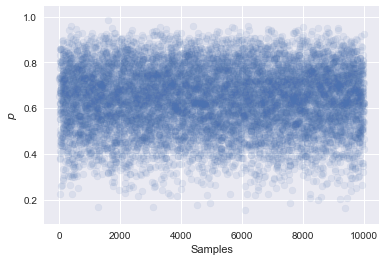

In [6]:
plt.scatter(range(nsamp),samples, alpha=0.1)
plt.xlabel('Samples')
plt.ylabel('$p$')

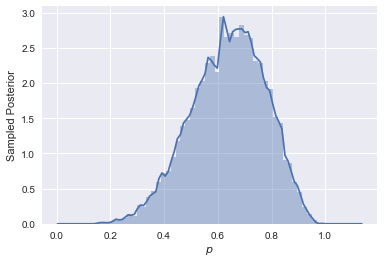

In [7]:
sns.distplot(samples,norm_hist=True, kde_kws={'bw':.05})
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')

In [8]:
quantiles=[np.percentile(samples,i) for i in [16,50,84]]
quantiles

[0.49549549549549549, 0.64664664664664662, 0.77977977977977975]

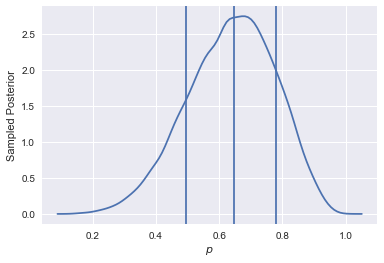

In [9]:
sns.kdeplot(samples)
for i in quantiles:
    plt.axvline(i)
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')

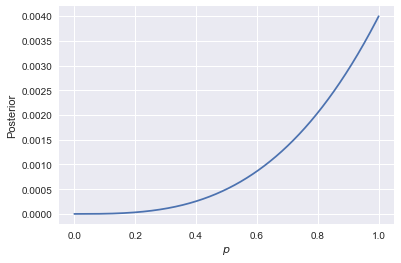

In [10]:
post_grid=np.array([posterior(i,3,3) for i in pgrid])
post_grid=post_grid/post_grid.sum()
plt.plot(pgrid,post_grid)
plt.xlabel('$p$')
plt.ylabel('Posterior')

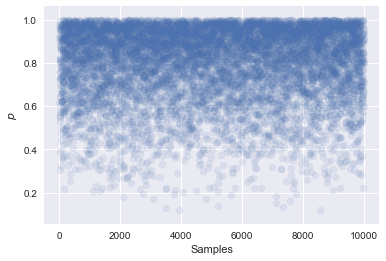

In [11]:
samples=np.random.choice(pgrid, nsamp, p=post_grid)
plt.scatter(range(nsamp),samples, alpha=0.1)
plt.xlabel('Samples')
plt.ylabel('$p$')

[0.63263263263263259, 0.84184184184184185, 0.95795795795795791]


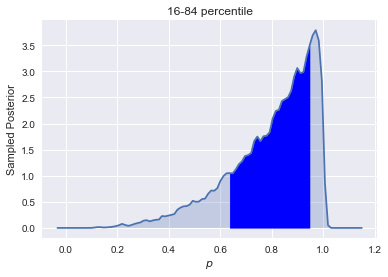

In [12]:
quantiles=[np.percentile(samples,i) for i in [16,50,84]]
print(quantiles)
points = sns.kdeplot(samples, shade=True,bw=0.05).get_lines()[0].get_data()

x = points[0]
y = points[1]

plt.fill_between(x,y, where = (x>=quantiles[0]) & (x<=quantiles[2]), color='b')
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')
plt.title('16-84 percentile')

In [13]:
# Highest Density Interval aka Highest Posterior Density Interval aka Minimum Width Bayesian Credible Interval
# To compute the X% HDI, you sort sample, then check all the X% intervals, and select the shortest
# https://stats.stackexchange.com/questions/252988/highest-density-interval-in-stan
# code from https://github.com/pymc-devs/pymc3/blob/master/pymc3/stats.py
# disclaimer: if distribution is bimodal it may fail (will only yield one interval)
x=np.sort(samples)
n = len(x)
cred_mass = 0.66

interval_idx_inc = int(np.floor(cred_mass * n))
n_intervals = n - interval_idx_inc
interval_width = x[interval_idx_inc:] - x[:n_intervals]

if len(interval_width) == 0:
    raise ValueError('Too few elements for interval calculation')

min_idx = np.argmin(interval_width)
hdi_min = x[min_idx]
hdi_max = x[min_idx + interval_idx_inc]
print(hdi_min, hdi_max)
quantiles=[hdi_min, hdi_max]

0.763763763764 1.0


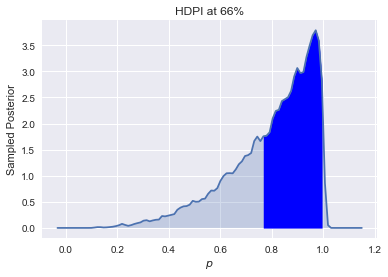

In [14]:
points = sns.kdeplot(samples, shade=True,bw=0.05).get_lines()[0].get_data()

x = points[0]
y = points[1]

plt.fill_between(x,y, where = (x>=quantiles[0]) & (x<=quantiles[1]), color='b')
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')
plt.title('HDPI at 66%')

In [15]:
def loss(pi,post_grid,pgrid): # L1 loss function
    return sum(post_grid*np.abs(pi-pgrid))

In [16]:
loss(0,post_grid,pgrid)

0.80040013333320037

In [17]:
loss_grid=np.array([loss(i,post_grid,pgrid) for i in pgrid])

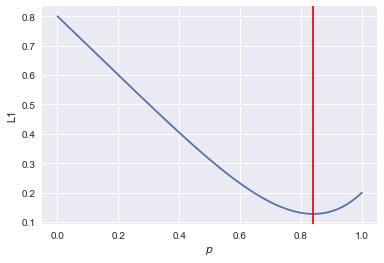

In [18]:
plt.plot(pgrid,loss_grid)
plt.axvline(pgrid[np.argmin(loss_grid)],c='r')
plt.ylabel('L1')
plt.xlabel('$p$')

In [19]:
pgrid[np.argmin(loss_grid)]

0.84084084084084088

In [20]:
np.median(samples)

0.84184184184184185

In [21]:
# Proof that median (50th percentile) minimizes the L1 loss function: 
# https://stats.stackexchange.com/questions/270428/how-do-i-show-that-the-sample-median-minimizes-the-sum-of-absolute-deviations

In [22]:
def loss2(pi,post_grid,pgrid):  # L2 loss function
    return sum(post_grid*(pi-pgrid)**2)

In [23]:
loss2(0,post_grid,pgrid)

0.66733366666633254

In [24]:
loss2(1,post_grid,pgrid)

0.066533399999933171

In [25]:
loss_grid=np.array([loss2(i,post_grid,pgrid) for i in pgrid])

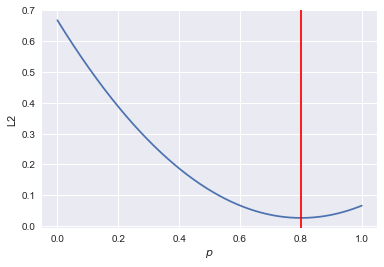

In [26]:
plt.plot(pgrid,loss_grid)
plt.axvline(pgrid[np.argmin(loss_grid)],c='r')
plt.ylabel('L2')
plt.xlabel('$p$')

In [27]:
pgrid[np.argmin(loss_grid)]

0.80080080080080074

In [28]:
np.mean(samples)

0.80039529529529529

In [29]:
# Proof that mean minimizes the L2 loss function: 
# https://math.stackexchange.com/a/2530425
# It's simpler than for L1 since L2's derivative is continuous

In [30]:
def disc_bins(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    return np.arange(left_of_first_bin, right_of_last_bin + d, d)

In [31]:
# predicting observations for p=2/3
synth_data=np.random.binomial(9,2/3,int(1e4))

(-0.5, 9.5)

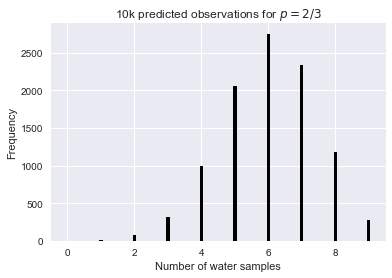

In [32]:
plt.hist(synth_data,rwidth=0.1,bins=disc_bins(synth_data),color='k')
plt.xlabel('Number of water samples')
plt.ylabel('Frequency')
plt.title('10k predicted observations for $p=2/3$')
plt.xlim(-0.5,9.5)

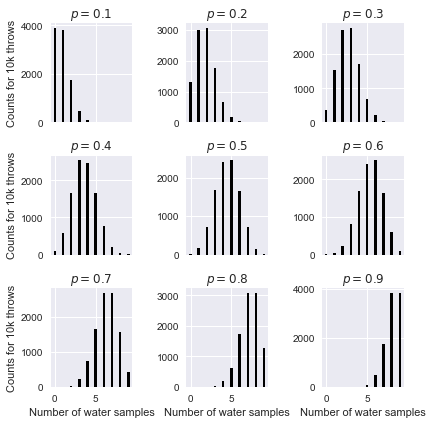

In [33]:
ix=1
fig, ax = plt.subplots(3, 3, sharex='col',figsize=(6,6))
for i in range(3):
    for j in range(3):
        p=ix/10
        ix+=1
        synth_data=np.random.binomial(9,p,int(1e4))
        ax[i,j].hist(synth_data,rwidth=0.3,bins=disc_bins(synth_data),color='k')
        ax[i,j].set_title('$p=%.1f$'%p)
        ax[i,j].set_xlim(-0.5,9.5)
        if i==2:
            ax[i,j].set_xlabel('Number of water samples')
        if j==0:
            ax[i,j].set_ylabel('Counts for 10k throws')
plt.tight_layout()


In [34]:
post_grid=np.array([posterior(i) for i in pgrid])
post_grid=post_grid/post_grid.sum()
nsamp=10000
samples=np.random.choice(pgrid, nsamp, p=post_grid)

In [35]:
ppd_samp=np.random.binomial(9,samples)

(-0.5, 9.5)

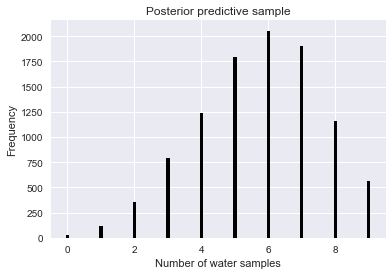

In [36]:
plt.hist(ppd_samp,rwidth=0.1,bins=disc_bins(ppd_samp),color='k')
plt.xlabel('Number of water samples')
plt.ylabel('Frequency')
plt.title('Posterior predictive sample')
plt.xlim(-0.5,9.5)

In [37]:
from itertools import groupby # helps count consecutive repetitions

In [38]:
n=9
repsw=[]
switch=[]
for p in samples:
    tarr=[]
    for i in range(n):
        tarr+=[np.random.binomial(1,p)]  
    wl=(''.join(str(e) for e in tarr)).count('10') # water to land is taken as '10'
    lw=(''.join(str(e) for e in tarr)).count('01') # land to water is taken as '01'
    switch+=[wl+lw] 
    dum=[]
    for group in groupby(range(n),lambda x: tarr[x]):
        if group[0]==1: # water is taken as 1
            dum+=[len(list(group[1]))] 
    if len(dum)==0:
        repsw+=[0]
    else:
        repsw+=[np.max(dum)]

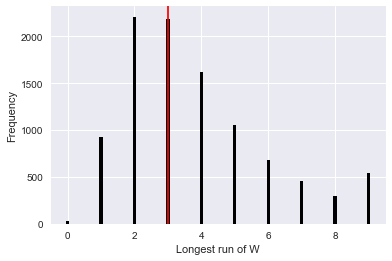

In [39]:
# 'W L W W W L W L W'
repsw=np.array(repsw)
plt.hist(repsw,rwidth=0.1,bins=disc_bins(repsw),color='k')
plt.axvline(3,c='r')
plt.xlabel('Longest run of W')
plt.ylabel('Frequency')

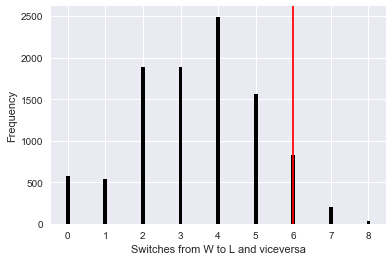

In [40]:
# 'W L W W W L W L W'
switch=np.array(switch)
plt.hist(switch,rwidth=0.1,bins=disc_bins(switch),color='k')
plt.axvline(6,c='r')
plt.xlabel('Switches from W to L and viceversa')
plt.ylabel('Frequency')